In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from configparser import ConfigParser
from keras.metrics import Precision,Recall,AUC,KLDivergence,Poisson,MeanAbsoluteError,F1Score,FBetaScore,CategoricalAccuracy
from keras.callbacks import EarlyStopping
import scipy
from ModelSelector import  ModelSelector
import keras_cv
import keras
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.callbacks import Callback
from keras_cv.models import ImageClassifier
from keras_cv.layers import RandAugment
from keras.models import Sequential
from LoadData import LoadData



ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (c:\Users\Sebas\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\preprocessing\image\__init__.py)

Cargamos las configuraciones necesarias

In [3]:
configfile_name = "config.ini" 
config= ConfigParser()
config.read(configfile_name)
image_size = int(config.get("dataset","image_size"))
color_mode=config.get("dataset","color_mode")
batch_size = int(config.get("dataset","batch_size"))
base_dir=config.get("dataset","base_dir")
dest_dir=config.get("dataset","dest_dir")

Cargamos el dataset

In [3]:
from SplitData import SplitData
data=SplitData()
data.split()

0.2
0.2
0.2


OSError: [WinError 145] The directory is not empty: 'Nuevo'

In [4]:
LoadData=LoadData(image_size,color_mode,batch_size)

In [5]:
train_ds=LoadData.load_train_data(dest_dir)
test_ds=LoadData.load_test_data(dest_dir)
val_ds=LoadData.load_validation_data(dest_dir)


Found 1161 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 231 files belonging to 3 classes.


In [44]:
def mostrar_imagenes(dataset):
    """
    Muestra las primeras 9 imágenes de un lote del dataset junto con sus etiquetas.
    Las etiquetas se infieren automáticamente desde el atributo `class_names` del dataset.

    Args:
        dataset (tf.data.Dataset): Dataset cargado con image_dataset_from_directory.
    """
    try:
        # Obtener nombres de las clases directamente del dataset
        class_names = dataset.class_names
    except AttributeError:
        raise ValueError("El dataset proporcionado no contiene información de `class_names`.")

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Tomar un lote del dataset
        for i in range(9):  # Mostrar las primeras 9 imágenes del lote
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Convertir etiquetas categóricas en nombres de clases
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()


Mostramos las diferentes clases del dataset

In [43]:
mostrar_imagenes(train_ds)

NameError: name 'mostrar_imagenes' is not defined

Seleccionamos algun modelo preentrenado (terminacion_pretrained) o su arquitectura de capas de nuestra clase Model Selector.
- resnet50
- resnet50_pretained
- resnet152
- cspdarknet
- cspdarknet_pretained
- densenet169
- densenet169_pretrained
- efficientnet
- efficientnet_V1
- efficientnet_V2_pretained
- efficientnet_V2
- mobilenet_V3_pretrained
- mobilenet_V3
- yolo_v8
- yolo_v8_pretained

In [9]:
backbone = ModelSelector(image_size=image_size, color_space=color_mode, model='efficientnet_V2_pretained').load_model()


100%|██████████| 1.79k/1.79k [00:00<?, ?B/s]

100%|██████████| 78.6M/78.6M [00:08<00:00, 9.62MB/s]


In [10]:
model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=3,
    activation="softmax",
    pooling="avg",
)

In [11]:
def build_model(hp, X_train):
    # Crear el objeto RandAugment con hiperparámetros ajustables
    augmenter = RandAugment(
        value_range=(0, 255),
        augmentations_per_image=hp.Int('augmentations_per_image', min_value=2, max_value=5, step=1, default=3),
        magnitude=hp.Float('magnitude', min_value=0.1, max_value=1.0, step=0.1, default=0.5),
        magnitude_stddev=hp.Float('magnitude_stddev', min_value=0.05, max_value=0.3, step=0.05, default=0.15),
        rate=hp.Float('rate', min_value=0.5, max_value=1.0, step=0.1, default=0.9),
        geometric=True
    )

    # Crear el modelo base
    model = ImageClassifier(
        backbone=backbone,
        num_classes=3,
        activation="softmax",
        pooling="avg"
    )

    # Aplicar las transformaciones de RandAugment a los datos de entrenamiento y validación
    X_train_aug = X_train.map(lambda x, y: (augmenter(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Compilar el modelo final
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model, X_train_aug

# Crear el tuner de Keras
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, X_train=train_ds)[0],  # Devuelve solo el modelo
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='rand_augment_tuning_effi'
)

# Ejecutar la búsqueda de hiperparámetros
tuner.search(x=train_ds, validation_data=val_ds, epochs=10)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Mejores hiperparámetros: {best_hps.values}')

# Crear el modelo final con los mejores hiperparámetros


Trial 10 Complete [01h 00m 34s]
val_loss: 0.1350744217634201

Best val_loss So Far: 0.08574290573596954
Total elapsed time: 05h 56m 29s
Mejores hiperparámetros: {'augmentations_per_image': 4, 'magnitude': 0.5, 'magnitude_stddev': 0.25, 'rate': 0.6}


In [12]:
final_model, X_train_aug = build_model(best_hps, X_train=train_ds)

In [10]:
%load_ext tensorboard

In [13]:
log_dir="./ckpt_effi_rand_augment"
checkpoint_dir=log_dir+'/ckpt'
checkpoint_filepath = checkpoint_dir+'/checkpoint_{epoch}.keras'

In [14]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,verbose=1,    save_best_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
csv_logger = tf.keras.callbacks.CSVLogger('training_log_effi_random.csv', append=True)


In [15]:
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [file for file in checkpoint_files if file.startswith('checkpoint_')]

In [16]:
print(checkpoint_files)

[]


In [17]:
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[  Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        MeanAbsoluteError(name='mae'),
        CategoricalAccuracy(name="categorical_accuracy", dtype=None),
         
         Poisson(name="poisson", dtype=None),
         ]
       

)


In [18]:
if checkpoint_files:
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1]
    last_epoch = int(latest_checkpoint.split('_')[1].split('.')[0])
    final_model = tf.keras.models.load_model(os.path.join(checkpoint_dir, latest_checkpoint))
else:
    print("No hay checkpoints.")
    last_epoch = 0  # Comienza desde la primera época

final_model.fit(
    X_train_aug,
    epochs=100,
    validation_data=val_ds,
    initial_epoch=last_epoch,
    callbacks=[ model_checkpoint_callback, early_stopping, reduce_lr, csv_logger,tensorboard_callback],
    

)

No hay checkpoints.
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - auc: 0.5280 - categorical_accuracy: 0.4058 - loss: 1.3696 - mae: 0.4445 - poisson: 0.7899 - precision: 0.3898 - recall: 0.1402
Epoch 1: val_loss improved from inf to 1.67336, saving model to ./ckpt_effi_rand_augment/ckpt/checkpoint_1.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 503s 10s/step - auc: 0.5286 - categorical_accuracy: 0.4064 - loss: 1.3689 - mae: 0.4442 - poisson: 0.7896 - precision: 0.3918 - recall: 0.1414 - val_auc: 0.6281 - val_categorical_accuracy: 0.5411 - val_loss: 1.6734 - val_mae: 0.3891 - val_poisson: 0.8893 - val_precision: 0.5805 - val_recall: 0.4372 - learning_rate: 1.0000e-05
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - auc: 0.6190 - categorical_accuracy: 0.4706 - loss: 1.1411 - mae: 0.4162 - poisson: 0.7137 - precision: 0.5744 - recall: 0.2197
Epoch 2: val_loss improved from 1.67336 to 0.99705, saving model to ./ckpt_effi_rand_augment/ckpt/checkpoint_2.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 353s 9s/st

In [61]:
#cargar el modelo
final_model=keras.saving.load_model('modelo_fin_effi.keras')

In [47]:
from keras import layers

simple_aug = keras.Sequential([
    layers.Resizing(96, 96),  # Redimensionar imágenes
    layers.RandomFlip("horizontal"),  # Volteo horizontal aleatorio
    layers.RandomRotation(factor=0.02),  # Rotación aleatoria
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Zoom aleatorio
    layers.RandomContrast(0.2),  # Aumentar o reducir el contraste
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Desplazamiento aleatorio
    layers.RandomBrightness(factor=0.2),  # Modificación del brillo
    layers.GaussianNoise(0.05),  # Ruido gaussiano para simular imperfecciones
])


In [48]:
# Función para aplicar aumentación varias veces
def augment_multiple_times(image, label, n=3):  # Generar 'n' variantes de cada imagen
    augmented_images = [simple_aug(image) for _ in range(n)]
    labels = [label for _ in range(n)]
    return tf.data.Dataset.from_tensor_slices((augmented_images, labels))

# Aplicar aumentación a cada imagen varias veces
augmented_dataset = test_ds.flat_map(lambda x, y: augment_multiple_times(x, y, n=3))



In [ ]:
def mostrar_imagenes(dataset, class_names):
    """
    Muestra las primeras 9 imágenes de un lote del dataset junto con sus etiquetas.

    Args:
        dataset (tf.data.Dataset): Dataset cargado con image_dataset_from_directory o transformado.
        class_names (list): Lista de nombres de clases.
    """
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Tomar un lote del dataset
        for i in range(9):  # Mostrar las primeras 9 imágenes del lote
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Convertir etiquetas categóricas en nombres de clases
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()

# Obtener los nombres de las clases desde el dataset original
class_names = train_ds.class_names

# Mostrar imágenes del dataset aumentado
mostrar_imagenes(augmented_dataset, class_names)

In [62]:
final_model.evaluate(augmented_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 437ms/step - auc: 0.9135 - categorical_accuracy: 0.7542 - loss: 0.5675 - mae: 0.2069 - poisson: 0.5225 - precision: 0.8149 - recall: 0.6917


c:\Users\Sebas\.pyenv\pyenv-win\versions\3.10.11\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.6688915491104126,
 0.7579618096351624,
 0.6611111164093018,
 0.8857793211936951,
 0.2237929254770279,
 0.7111111283302307,
 0.5562970638275146]

In [63]:
y_pred=final_model.predict(augmented_dataset)
y_pred_label=np.argmax(y_pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


In [64]:
import numpy as np
import tensorflow as tf

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in augmented_dataset:
    preds = final_model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Obtener la clase predicha
    true_labels.extend(np.argmax(labels, axis=1))  # Obtener la clase verdadera

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


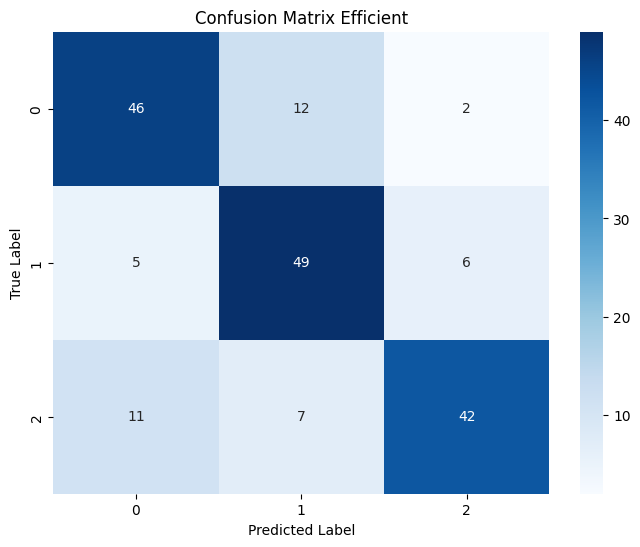

In [66]:
# Crear la matriz de confusión
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convertir a numpy para facilitar la visualización
cm = cm.numpy()

# Visualizar la matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Efficient')
plt.show()

In [23]:
final_model.save("modelo_fin_effi.keras")